In [150]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [327]:
# Read all data files of one category.
import os

category = 'plastic'
downsample_steps = {'alive': 2, 'fibro': 5, 'plastic': 5}  # TODO: Rename var.

data_dir = 'data/JulianTrajs/' + category
trajectories = []
filenames = os.listdir(data_dir)    
for filename in filenames:
    trajectory = np.genfromtxt(os.path.join(data_dir, filename))
#     for start in range(1):
#         end = -(downsample_steps[category] - start)
#         sliced_trajectory = trajectory[start:end:downsample_steps[category]]
    trajectories.append(trajectory[::downsample_steps[category]])
trajectories = np.array(trajectories)

print "Category {}: Found {} files, created {} trajectories".format(category, len(filenames), len(trajectories))

Category plastic: Found 177 files, created 177 trajectories


In [328]:
# This is not in um/min because no resampling was used for prediction.
def to_velocities(x, multiple_trajectories=False):
    return np.diff(x, axis=int(multiple_trajectories)) #/ 5.
# TODO: Does only work for single trajectory right now, extend to multiple trajectories if needed.
def to_positions(x):
    return np.append(np.zeros((1, 3)), np.cumsum(x , axis=0), axis=0)#* 5., axis=0), axis=0)

In [329]:
trajectories = to_velocities(trajectories, multiple_trajectories=True)

In [330]:
# Normalize trajectories to [-1, 1] for the LSTM network (it outputs values between -1 and 1 by default)
# TODO: Do not use min/max values here but fixed value to generalize to other datasets.

# TODO: Normalize by just dividigng through abs_max_value (i. e. not moving the mean).

min_value = np.min(trajectories)
max_value = np.max(trajectories)
abs_max_value = max(abs(min_value), abs(max_value))
print abs_max_value
def normalize(x):
    #return x / abs_max_value
    return np.interp(x, [min_value, max_value], [-1., 1.])
def denormalize(x):
    #return x * abs_max_value
    return np.interp(x, [-1., 1.], [min_value, max_value])
    

48.116587


In [ ]:
# Normalize to mean 0 and standard deviation 0.5.
# TODO: Evaluate if this is better than normalizing to [-1, 1].
traj_means = np.mean(trajectories, axis=(0, 1))
traj_stds = np.std(trajectories, axis=(0, 1))
#traj_stds[traj_stds == 0] = 1.  # Fix zero stds by setting them to 0.

def normalize(x):
    return np.nan_to_num((x - traj_means) / (3. * traj_stds))
def denormalize(x):
    return x * 3. * traj_stds + traj_means

In [331]:
trajectories = normalize(trajectories)

In [332]:
np.mean(trajectories, axis=(0, 1)), np.std(trajectories, axis=(0, 1))
# fibro, norm by dividing through abs_max_value: 0.0015, 0.0015, 0
# fibro, norm to [-1, 1]: 0.12, 0.12, 0.11
# fibro, norm to [0, 1]: 0.558, 0.558, 0.557

(array([-0.12831537, -0.12740698, -0.1274353 ]),
 array([  6.68431155e-02,   7.43936720e-02,   2.23987495e-14]))

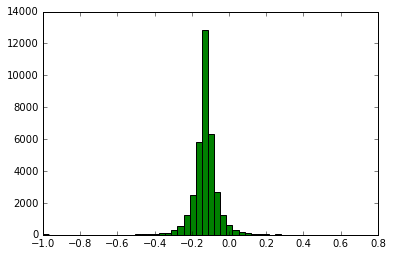

In [333]:
n, bins, patches = plt.hist(trajectories[:, :, 0].flatten(), bins=51, facecolor='green')

In [334]:
batch_size = len(trajectories)
num_timesteps = len(trajectories[0])

In [335]:
# Layer implementing a Gaussian mixture model.
# Implementation largely follows https://github.com/fchollet/keras/issues/1061.
# In contrast to the original code, the loss was divided by sqrt(2 pi) to use the same Gaussian as in numpy.random.norm 

from keras.layers import Layer
# TODO: This is only implemented for theano, rewrite it using keras.backend (as an exercise).
import theano
import theano.tensor as T

class GMMActivation(Layer):
    """
    GMM-like activation function.
    Assumes that input has (D+2)*M dimensions, where D is the dimensionality of the 
    target data. The first M*D features are treated as means, the next M features as 
    standard devs and the last M features as mixture components of the GMM. 
    """
    def __init__(self, M, **kwargs):
        super(GMMActivation, self).__init__(**kwargs)
        self.M = M

    def get_output(self, train=False):
        X = self.get_input(train)
        D = T.shape(X)[1]/self.M - 2
        # leave mu values as they are since they're unconstrained
        # scale sigmas with exp, s.t. all values are non-negative 
        X = T.set_subtensor(X[:,D*self.M:(D+1)*self.M], T.exp(X[:,D*self.M:(D+1)*self.M]))
        # scale alphas with softmax, s.t. that all values are between [0,1] and sum up to 1
        X = T.set_subtensor(X[:,(D+1)*self.M:(D+2)*self.M], T.nnet.softmax(X[:,(D+1)*self.M:(D+2)*self.M]))
        return X

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "M": self.M}
        base_config = super(GMMActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def gmm_loss(y_true, y_pred):
    """
    GMM loss function.
    Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first 
    M*D features are treated as means, the next M features as standard devs and the last 
    M features as mixture components of the GMM. 
    """
    def loss(m, M, D, y_true, y_pred):
        mu = y_pred[:,D*m:(m+1)*D]
        sigma = y_pred[:,D*M+m]
        alpha = y_pred[:,(D+1)*M+m]
        return (alpha/sigma/np.sqrt(2. * np.pi)) * T.exp(-T.sum(T.sqr(mu-y_true),-1)/(2*sigma**2))

    D = T.shape(y_true)[1]
    M = T.shape(y_pred)[1]/(D+2)
    seq = T.arange(M)
    result, _ = theano.scan(fn=loss, outputs_info=None, 
    sequences=seq, non_sequences=[M, D, y_true, y_pred])
    return -T.log(result.sum(0))

In [336]:
# Set up the network.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, 1, 3), output_dim=10, return_sequences=False, stateful=True))
# model.add(LSTM(batch_input_shape=(batch_size, 1, 3), output_dim=100, return_sequences=True, stateful=True))

#model.add(LSTM(output_dim=10, return_sequences=False, stateful=True))
#model.add(LSTM(output_dim=100, return_sequences=True, stateful=True))

#model.add(LSTM(output_dim=100, return_sequences=True, stateful=True))
#model.add(LSTM(output_dim=100, return_sequences=False, stateful=True))
num_mixture_components = 10  # TODO: Play around with this parameter.
model.add(Dense( (3+2) * num_mixture_components ))
model.add(GMMActivation(num_mixture_components))
model.compile(loss=gmm_loss, optimizer=RMSprop(lr=0.001))

D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:23: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:51: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [337]:
losses = []

In [338]:
# Train on complete trajectories.
num_epochs = 300
model.reset_states()
for epoch in range(1, num_epochs+1):
    print 'Epoch', epoch,
    losses_epoch = []
    for i in range(num_timesteps - 1):
        results = model.train_on_batch(trajectories[:, i:i+1], trajectories[:, i+1])
        losses_epoch.append(results[0])
    mean_loss = np.mean(losses_epoch)
    print '- loss:', mean_loss
    losses.append(mean_loss)
    model.reset_states()

Epoch 1 - loss: 0.429314282007
Epoch 2 - loss: -0.892840943939
Epoch 3 - loss: -0.924454009082
Epoch 4 - loss: -0.937840492258
Epoch 5 - loss: -0.946719426296
Epoch 6 - loss: -0.953109727981
Epoch 7 - loss: -0.957881014307
Epoch 8 - loss: -0.961565068579
Epoch 9 - loss: -0.964437990216
Epoch 10 - loss: -0.96674476121
Epoch 11 - loss: -0.968820956993
Epoch 12 - loss: -0.970644911359
Epoch 13 - loss: -0.972300207421
Epoch 14 - loss: -0.97381491295
Epoch 15 - loss: -0.975175332393
Epoch 16 - loss: -0.976385330778
Epoch 17 - loss: -0.977497503997
Epoch 18 - loss: -0.978531518181
Epoch 19 - loss: -0.979483393831
Epoch 20 - loss: -0.980301329224
Epoch 21 - loss: -0.981093616741
Epoch 22 - loss: -0.981851740628
Epoch 23 - loss: -0.982472878333
Epoch 24 - loss: -0.983139830661
Epoch 25 - loss: -0.983779664981
Epoch 26 - loss: -0.984331880577
Epoch 27 - loss: -0.984877366631
Epoch 28 - loss: -0.985416065006
Epoch 29 - loss: -0.985920928593
Epoch 30 - loss: -0.986425924404
Epoch 31 - loss: -0.98

KeyboardInterrupt: 

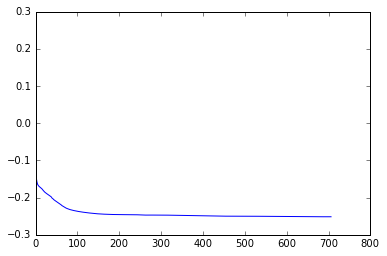

In [309]:
plt.plot(losses)

In [340]:
# Predict next timesteps using the training data as input (i. e. not the predictions themselves!).
model.reset_states()
predicted = []
predicted.append(trajectories[:, 0])  # Take first timestep from training data so predicted and expected have the same dimensions.

for i in range(num_timesteps - 1):
    pred_parameters = model.predict_on_batch(trajectories[:, i:i+1])[0]
    means = pred_parameters[:, :num_mixture_components * 3]
    sds = pred_parameters[:, num_mixture_components * 3:num_mixture_components * (3 + 1)]
    weights = pred_parameters[:, num_mixture_components * (3 + 1):]
    
    # Reshape arrays to allow broadcasting of means (3-dimensional vectors) and sds/weights (scalars).
    means = means.reshape(-1, num_mixture_components, 3)
    sds = sds[:, :, np.newaxis]
    weights = weights[:, :, np.newaxis]
    
    pred = weights * np.random.normal(means, sds)
    pred = np.sum(pred, axis=1)
    predicted.append(pred)
    
predicted = np.array(predicted)
predicted = predicted.transpose((1, 0, 2))
expected = trajectories

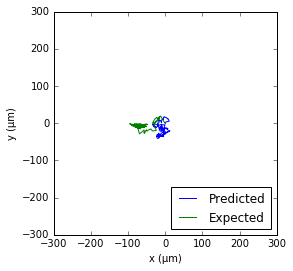

In [344]:
# Plot single trajectory from velocities.
i_traj = 1
pr = to_positions(denormalize(predicted[i_traj]))
plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
exp = to_positions(denormalize(expected[i_traj]))
plt.plot(exp[:, 0], exp[:, 1], label='Expected')
lim = 300#abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.xlabel(u'x (\u00b5m)')
plt.ylabel(u'y (\u00b5m)')
plt.legend(loc='lower right')
plt.gca().set(adjustable='box-forced', aspect='equal')

#plt.savefig('plots/{}-{}.png'.format(category, i_traj), dpi=300)

(-300, 300)

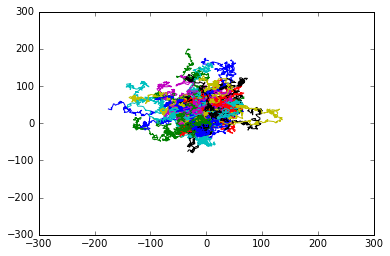

In [307]:
# Plot multiple trajectories from velocities.
for traj in predicted:
    pr = to_positions(denormalize(traj))
    plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
lim = 300#abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

In [203]:
# Predict new trajectories one timestep after another using a seed.

len_seed = 20  # TODO: Play around with seed size.
predicted = np.zeros((batch_size, num_timesteps, 3))

# Take starts of training trajectories as seed.
predicted[:, :len_seed] = trajectories[:, :len_seed]

# Take random values as seed.
#predicted[:, :len_seed] = 2. * (np.random.rand(batch_size, len_seed, 3) - 0.5)

# Disable both lines above to take 0 values as seed.

model.reset_states()

log_traj = 0
    
for i in range(num_timesteps - 1):
    model_input = predicted[:, i:i+1]
    pred_parameters = model.predict_on_batch(model_input)[0]
    
    means = pred_parameters[:, :num_mixture_components * 3]
    sds = pred_parameters[:, num_mixture_components * 3:num_mixture_components * (3 + 1)]
    weights = pred_parameters[:, num_mixture_components * (3 + 1):]
        
    # Reshape arrays to allow broadcasting of means (3-dimensional vectors) and sds/weights (scalars).
    means = means.reshape(-1, num_mixture_components, 3)
    sds = sds[:, :, np.newaxis]
    weights = weights[:, :, np.newaxis]
    
    pred = weights * np.random.normal(means, sds)
    pred = np.sum(pred, axis=1)    
    model_output = pred
    
    # Add random noise to the output values.
    #model_output += 0.25 * (np.random.rand(batch_size, 3) - 0.5)
    
    print 'Tr {}, step {}: In: {} - Out: {}'.format(log_traj, i, model_input[log_traj], model_output[log_traj]), 
    
    if i+1 >= len_seed:
        predicted[:, i+1] = model_output
        print '--> Storing at {}'.format(i+1)
    else:
        print '--> Seed'

expected = trajectories

Tr 0, step 0: In: [[-0.11929745 -0.16926699 -0.1274353 ]] - Out: [-0.07543063 -0.05903367 -0.07567553] --> Seed
Tr 0, step 1: In: [[-0.1269096  -0.23584018 -0.1274353 ]] - Out: [-0.06460239 -0.10555829 -0.19765334] --> Seed
Tr 0, step 2: In: [[-0.13533153 -0.18214361 -0.1274353 ]] - Out: [-0.11142873 -0.11718103 -0.12200553] --> Seed
Tr 0, step 3: In: [[-0.21454122 -0.09839719 -0.1274353 ]] - Out: [-0.24823113 -0.23943736 -0.19145711] --> Seed
Tr 0, step 4: In: [[-0.21283643 -0.04382512 -0.1274353 ]] - Out: [-0.34343137 -0.0823497  -0.09680619] --> Seed
Tr 0, step 5: In: [[-0.17235168 -0.13002572 -0.1274353 ]] - Out: [-0.17550509 -0.1589601   0.01969278] --> Seed
Tr 0, step 6: In: [[-0.18961012 -0.10719503 -0.1274353 ]] - Out: [-0.15862429 -0.02779072 -0.10346575] --> Seed
Tr 0, step 7: In: [[-0.26534981 -0.05835042 -0.1274353 ]] - Out: [-0.30202523 -0.08380032 -0.23723742] --> Seed
Tr 0, step 8: In: [[-0.16319002 -0.07215143 -0.1274353 ]] - Out: [-0.04633253 -0.21989403 -0.07649696] -

In [204]:
np.mean(predicted, axis=(0, 1))
# fibro, norm to 0.33 std, 100 epochs: 0.10, 0.035, 0
# fibro, norm by dividing through abs_max_value, 100 epochs: 0.009, -0.015, -0.002
# fibro, norm by dividing through abs_max_value, 100 epochs: 0.017, -0.008, -0.002
# fibro, norm to [-1, 1], 100 epochs: 0.135, 0.115, 0.115 (minus default ca. 0.02, 0, 0)
# fibro, norm to [-1, 1], 200 epochs: 0.125, 0.110, 0.113 (minus default ca. 0.01, -0.006, -0.003)
# fibro, norm to [-1, 1], 500 epochs: 0.135, 0.115, 0.115 (minus default ca. 0.02, 0, 0)


array([-0.13174982, -0.13735447, -0.12737937])

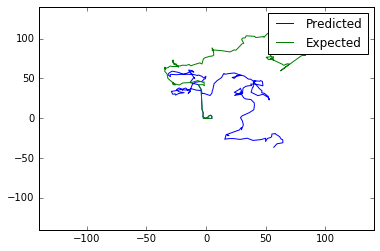

In [205]:
# Plot single trajectory from velocities.
i_traj = 3
pr = to_positions(denormalize(predicted[i_traj]))
plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
exp = to_positions(denormalize(expected[i_traj]))
plt.plot(exp[:, 0], exp[:, 1], label='Expected')
lim = abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.legend()

(-300, 300)

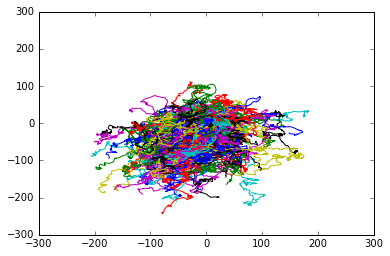

In [206]:
# Plot multiple trajectories from velocities.
for traj in predicted:
    pr = to_positions(denormalize(traj))
    plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
lim = 300#abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

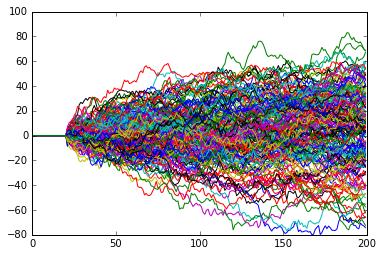

In [190]:
for traj in predicted:
    pr = to_positions(denormalize(traj))
    plt.plot(pr[:, 2])

In [ ]:
to_positions(denormalize(predicted[0]))[:]

In [189]:
# Save generated trajectories to file.
for i, trajectory in enumerate(predicted):
    np.savetxt('data/generated/{}/cell{:03d}.dat'.format(category, i+1), to_positions(denormalize(trajectory)))

In [ ]:
len(predicted[0])